https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb#scrollTo=qnaiLGuDbiJe

https://woochan-autobiography.tistory.com/871

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('삼성바이오로직스 주식 데이터.csv',encoding='cp949', parse_dates = ["날짜"])
data1 = pd.read_csv('삼성바이오로직스 주식 데이터(투자주체별).csv',encoding='cp949', parse_dates = ["날짜"])

In [16]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      249 non-null    datetime64[ns]
 1   개인      249 non-null    int64         
 2   외국인     249 non-null    int64         
 3   기관계     249 non-null    int64         
 4   금융투자    249 non-null    int64         
 5   보험      249 non-null    int64         
 6   투신      249 non-null    int64         
 7   은행      249 non-null    int64         
 8   기타금융    249 non-null    int64         
 9   연기금     249 non-null    int64         
 10  기타법인    249 non-null    int64         
 11  기타외인    249 non-null    int64         
 12  사모펀드    249 non-null    int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 25.4 KB


In [ ]:
data.columns, data1.columns

(Index(['종목코드', '종목명', '날짜', '시간', '시가', '고가', '저가', '종가', '거래량', '거래대금',
        '누적체결매도수량', '누적체결매수수량'],
       dtype='object'),
 Index(['종목코드', '종목명', '날짜', '개인', '외국인', '기관계', '금융투자', '보험', '투신', '은행',
        '기타금융', '연기금', '기타법인', '기타외인', '사모펀드'],
       dtype='object'))

In [5]:
data.drop('종목코드', axis=1, inplace=True) 
data.drop('종목명', axis=1, inplace=True) 
data1.drop('종목코드', axis=1, inplace=True) 
data1.drop('종목명', axis=1, inplace=True) 

In [6]:
m_data = pd.merge(data, data1)
m_data.drop('누적체결매도수량', axis=1, inplace=True)
m_data.drop('누적체결매수수량', axis=1, inplace=True)

투자주체별 합치고 종가 삭제하고

In [17]:
# 날짜 - 날짜형으로 변경
m_data['날짜'] = pd.to_datetime(data['날짜'])

In [18]:
m_data['Year'] = m_data['날짜'].dt.year
m_data['Month'] = m_data['날짜'].dt.month
m_data['Day'] = m_data['날짜'].dt.day

m_data.drop('날짜', axis = 1, inplace=True)

In [19]:
m_data.columns

Index(['시간', '시가', '고가', '저가', '종가', '거래량', '거래대금', '개인', '외국인', '기관계', '금융투자',
       '보험', '투신', '은행', '기타금융', '연기금', '기타법인', '기타외인', '사모펀드', 'Year',
       'Month', 'Day'],
      dtype='object')

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['시간', '시가', '고가', '저가', '종가', '거래량', '거래대금',
       '개인', '외국인', '기관계', '금융투자', '보험', '투신', '은행', '기타금융', '연기금', '기타법인',
       '기타외인', '사모펀드', 'Year', 'Month', 'Day']
# 스케일 후 columns
scaled = scaler.fit_transform(m_data[scale_cols])
scaled

array([[0.        , 0.40883978, 0.41111111, ..., 0.        , 0.45454545,
        0.5       ],
       [0.00137174, 0.4198895 , 0.41666667, ..., 0.        , 0.45454545,
        0.5       ],
       [0.00274348, 0.40331492, 0.43333333, ..., 0.        , 0.45454545,
        0.5       ],
       ...,
       [0.84773663, 0.03314917, 0.02777778, ..., 1.        , 0.45454545,
        0.63333333],
       [0.84910837, 0.03314917, 0.02777778, ..., 1.        , 0.45454545,
        0.63333333],
       [0.86282579, 0.03314917, 0.02777778, ..., 1.        , 0.45454545,
        0.63333333]])

In [22]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94786 entries, 0 to 94785
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시간      94786 non-null  float64
 1   시가      94786 non-null  float64
 2   고가      94786 non-null  float64
 3   저가      94786 non-null  float64
 4   종가      94786 non-null  float64
 5   거래량     94786 non-null  float64
 6   거래대금    94786 non-null  float64
 7   개인      94786 non-null  float64
 8   외국인     94786 non-null  float64
 9   기관계     94786 non-null  float64
 10  금융투자    94786 non-null  float64
 11  보험      94786 non-null  float64
 12  투신      94786 non-null  float64
 13  은행      94786 non-null  float64
 14  기타금융    94786 non-null  float64
 15  연기금     94786 non-null  float64
 16  기타법인    94786 non-null  float64
 17  기타외인    94786 non-null  float64
 18  사모펀드    94786 non-null  float64
 19  Year    94786 non-null  float64
 20  Month   94786 non-null  float64
 21  Day     94786 non-null  float64
dty

train/test 분리

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_7680\3628187252.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)


In [25]:
x_test.columns

Index(['시간', '시가', '고가', '저가', '거래량', '거래대금', '개인', '외국인', '기관계', '금융투자', '보험',
       '투신', '은행', '기타금융', '연기금', '기타법인', '기타외인', '사모펀드', 'Year', 'Month',
       'Day'],
      dtype='object')

In [47]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75828 entries, 0 to 75827
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시간      75828 non-null  float64
 1   시가      75828 non-null  float64
 2   고가      75828 non-null  float64
 3   저가      75828 non-null  float64
 4   거래량     75828 non-null  float64
 5   거래대금    75828 non-null  float64
 6   개인      75828 non-null  float64
 7   외국인     75828 non-null  float64
 8   기관계     75828 non-null  float64
 9   금융투자    75828 non-null  float64
 10  보험      75828 non-null  float64
 11  투신      75828 non-null  float64
 12  은행      75828 non-null  float64
 13  기타금융    75828 non-null  float64
 14  연기금     75828 non-null  float64
 15  기타법인    75828 non-null  float64
 16  기타외인    75828 non-null  float64
 17  사모펀드    75828 non-null  float64
 18  Year    75828 non-null  float64
 19  Month   75828 non-null  float64
 20  Day     75828 non-null  float64
dtypes: float64(21)
memory usage: 12.7 M

시퀀스 데이터셋 구성

In [27]:
import tensorflow as tf

In [28]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [29]:
# 하이퍼 파라미터
WINDOW_SIZE=20
BATCH_SIZE=32

In [30]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [31]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [33]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [34]:
import os

In [35]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [36]:
test_data 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [37]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50


   2365/Unknown - 12s 4ms/step - loss: 3.8384e-04 - mse: 7.6768e-04
Epoch 1: val_loss improved from inf to 0.00002, saving model to tmp\ckeckpointer.ckpt
2369/2369 [==============================] - 14s 4ms/step - loss: 3.8324e-04 - mse: 7.6647e-04 - val_loss: 1.6288e-05 - val_mse: 3.2575e-05
Epoch 2/50
2355/2369 [============================>.] - ETA: 0s - loss: 2.3750e-05 - mse: 4.7499e-05
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to tmp\ckeckpointer.ckpt
2369/2369 [==============================] - 10s 4ms/step - loss: 2.3705e-05 - mse: 4.7409e-05 - val_loss: 1.1760e-05 - val_mse: 2.3521e-05
Epoch 3/50
2368/2369 [============================>.] - ETA: 0s - loss: 2.0304e-05 - mse: 4.0608e-05
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckpointer.ckpt
2369/2369 [==============================] - 9s 4ms/step - loss: 2.0299e-05 - mse: 4.0599e-05 - val_loss: 1.0646e-05 - val_mse: 2.1292e-05
Epoch 4/50
2359/2369 [=======================

In [38]:
model.load_weights(filename)

In [39]:
print(test_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [40]:
pred = model.predict(test_data)

592/592 [==============================] - 1s 2ms/step


In [41]:
pred

array([[0.42132536],
       [0.42145282],
       [0.42147717],
       ...,
       [0.02871703],
       [0.02754015],
       [0.02931293]], dtype=float32)

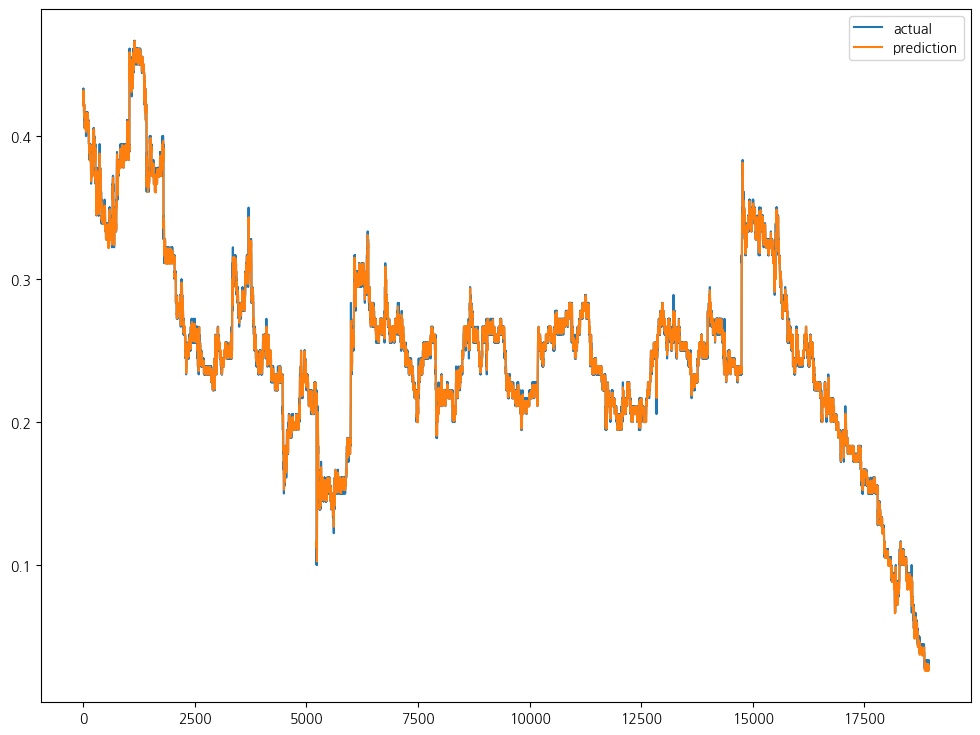

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()